In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- We need to recreate the predictions to align them properly ---

# 1. Load the processed data
DATA_FILE = "../data/processed/all_features.parquet"
df = pd.read_parquet(DATA_FILE)
df.index = pd.to_datetime(df.index)

# 2. Re-create the test set predictions from Notebook 3
# We need all the same setup steps
features = df.drop(columns=['target_5d_forward_return', 'ticker']).select_dtypes(include=np.number)
target = df['target_5d_forward_return']
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(features.median(), inplace=True)

split_date = '2023-01-01'
X_train = features[features.index < split_date]
X_test = features[features.index >= split_date]
y_train = target[target.index < split_date]
y_test = target[target.index >= split_date]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train the Random Forest Model Again ---
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

# 3. Add predictions to our test set DataFrame
# This is crucial for backtesting
test_df = df[df.index >= split_date].copy()
test_df['prediction'] = predictions

print("Data loaded and predictions aligned.")
test_df[['ticker', 'target_5d_forward_return', 'prediction']].head()

Data loaded and predictions aligned.


,ticker,target_5d_forward_return,prediction
Date,,,
2023-01-03,BA,0.056750,0.012589
2023-01-04,BA,0.075264,-0.009407
2023-01-05,BA,0.038965,0.000780
2023-01-06,BA,0.032635,-0.018137
2023-01-09,BA,0.001648,-0.010823


In [2]:
def generate_signals(data):
    # For each day, rank the stocks based on their prediction
    # 'groupby(level=0)' groups the data by its index (the date)
    data['rank'] = data.groupby(level=0)['prediction'].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates='drop')
    )
    
    # Generate signals: 1 for Long (top quintile), -1 for Short (bottom quintile)
    data['signal'] = 0
    data.loc[data['rank'] == 4, 'signal'] = 1  # Long signal for the top 20%
    data.loc[data['rank'] == 0, 'signal'] = -1 # Short signal for the bottom 20%
    
    return data

backtest_data = generate_signals(test_df)

print("Trading signals generated.")
# Check the signals for a specific date
backtest_data[['ticker', 'prediction', 'rank', 'signal']].loc['2023-01-03'].head()

Trading signals generated.


,ticker,prediction,rank,signal
Date,,,,
2023-01-03,BA,0.012589,4,1
2023-01-03,A,-0.024698,0,-1
2023-01-03,MO,0.002647,3,0
2023-01-03,CDNS,-0.008537,1,0
2023-01-03,CHTR,0.036021,4,1


In [3]:
# Calculate the daily returns of our strategy
# We assume we enter the position and hold for 1 day to calculate the return
# The 'signal' determines if we are long (+1) or short (-1) that stock
# The actual return is the next day's open-to-open return, but we'll use close-to-close for simplicity
# We shift the signal by 1 day to avoid lookahead bias (we use today's signal for tomorrow's return)

# Calculate daily returns for each stock
backtest_data['daily_return'] = backtest_data.groupby('ticker')['Close'].pct_change()

# Calculate strategy returns
# For each day, the portfolio return is the average return of all selected stocks
# We multiply the stock's return by its signal (1 for long, -1 for short)
# We shift the signal by 1 because we use today's close signal to trade for tomorrow's return
backtest_data['strategy_return'] = backtest_data['daily_return'] * backtest_data['signal'].shift(1)

# The total portfolio return for a given day is the average of all individual strategy returns
daily_portfolio_returns = backtest_data.groupby(level=0)['strategy_return'].mean()

# Calculate cumulative returns to see the overall growth
cumulative_returns = (1 + daily_portfolio_returns).cumprod() - 1

print("Backtest complete. Portfolio returns calculated.")

Backtest complete. Portfolio returns calculated.


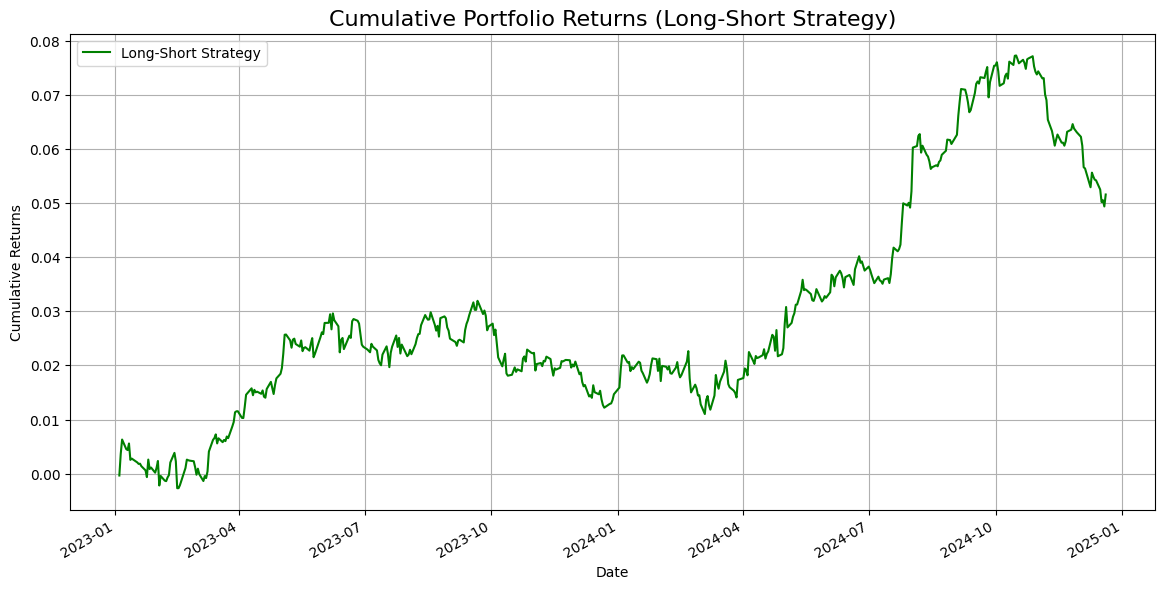


--- Strategy Performance Metrics ---
Sharpe Ratio: 1.01
Maximum Drawdown: -2.59%
Hit Rate (Profitable Days): 51.41%


In [4]:
# --- Performance Visualization ---
plt.figure(figsize=(14, 7))
cumulative_returns.plot(label='Long-Short Strategy', color='green')
plt.title('Cumulative Portfolio Returns (Long-Short Strategy)', fontsize=16)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# --- Performance Metrics ---
# Sharpe Ratio (assuming risk-free rate is 0)
sharpe_ratio = (daily_portfolio_returns.mean() * 252) / (daily_portfolio_returns.std() * np.sqrt(252))

# Maximum Drawdown
rolling_max = (cumulative_returns + 1).cummax()
daily_drawdown = (cumulative_returns + 1) / rolling_max - 1
max_drawdown = daily_drawdown.min()

# Hit Rate (% of profitable days)
hit_rate = (daily_portfolio_returns > 0).sum() / len(daily_portfolio_returns)

print("\n--- Strategy Performance Metrics ---")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Hit Rate (Profitable Days): {hit_rate:.2%}")